In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
words = open('names.txt','r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [3]:
len(words)

32033

In [4]:
# building vocab from chars to ints
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{0: '.',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'j',
 10: 'k',
 11: 'l',
 12: 'm',
 13: 'n',
 14: 'o',
 15: 'p',
 16: 'q',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'x',
 24: 'y',
 25: 'z'}

In [5]:
# build dataset

block_size = 3 # context length
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... --> e
..e --> m
.em --> m
emm --> .
mm. --> .
olivia
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> .
vi. --> .
ava
... --> .
... --> v
..v --> .
.v. --> .
isabella
... --> i
..i --> s
.is --> .
is. --> b
s.b --> e
.be --> l
bel --> l
ell --> .
ll. --> .
sophia
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> .
hi. --> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  4],
        [ 0,  4, 12],
        [ 4, 12, 12],
        [12, 12,  0],
        [ 0,  0,  0],
        [ 0,  0, 14],
        [ 0, 14, 11],
        [14, 11,  8],
        [11,  8, 21],
        [ 8, 21,  8],
        [21,  8,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0, 21],
        [ 0, 21,  0],
        [ 0,  0,  0],
        [ 0,  0,  8],
        [ 0,  8, 18],
        [ 8, 18,  0],
        [18,  0,  1],
        [ 0,  1,  4],
        [ 1,  4, 11],
        [ 4, 11, 11],
        [11, 11,  0],
        [ 0,  0,  0],
        [ 0,  0, 18],
        [ 0, 18, 14],
        [18, 14, 15],
        [14, 15,  7],
        [15,  7,  8],
        [ 7,  8,  0]])

In [8]:
Y

tensor([ 4, 12, 12,  0,  0, 14, 11,  8, 21,  8,  0,  0,  0, 21,  0,  0,  8, 18,
         0,  1,  4, 11, 11,  0,  0, 18, 14, 15,  7,  8,  0,  0])

In [9]:
# embedding matrix 27 chars have 2 col embeddings
C = torch.randn(27,2) # each row tells index mapping so for '5' index character we can get C[5]
# or we can do F.one_hot(torch.tensor(5), num_classes=27)

In [10]:
C[5]

tensor([0.9762, 0.8939])

In [11]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.9762, 0.8939])

In [12]:
C[torch.tensor([5,6,7,7,7])] # getting row 5,6,7

tensor([[ 0.9762,  0.8939],
        [ 1.1338, -1.0887],
        [-1.3011, -0.4254],
        [-1.3011, -0.4254],
        [-1.3011, -0.4254]])

In [13]:
# python indexing is very flexible we can just do 
C[X].shape

torch.Size([32, 3, 2])

In [14]:
X[13,2] 

tensor(0)

In [15]:
# embedding of X[13,2]
C[X][13, 2]

tensor([ 0.4770, -1.7420])

In [16]:
C[0] # first row of integer is same

tensor([ 0.4770, -1.7420])

In [17]:
C = torch.randn(27, 2) # embedding 
emb = C[X]
emb.shape # samplex x context x embeddings

torch.Size([32, 3, 2])

In [18]:
# weights 
W1 = torch.randn((6,100)) # 3x2 context
b1 = torch.randn((100))

In [19]:
emb * W1 + b1 # will not work bec [32, 3, 2] x [6, 100]
# so we need to concact it 

RuntimeError: The size of tensor a (2) must match the size of tensor b (100) at non-singleton dimension 2

In [ ]:
emb[:,0,:].shape # embedding of 1st char for every sample

torch.Size([32, 2])

In [ ]:
torch.cat(
    [emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]],
).shape 
# we need to concat across dim 1 not 0 

torch.Size([96, 2])

In [ ]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape # torch.cat takes seq of input hence list

torch.Size([32, 6])

In [ ]:
# unbind removes tensor dimension and returns tuple of those dimensions
# emb.shape -> torch.Size([32, 3, 2])
len(torch.unbind(emb, 1)) # context 

3

In [ ]:
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

torch.Size([32, 6])

### view

In [ ]:
# better way is view 
emb.shape

torch.Size([32, 3, 2])

In [ ]:
emb.view(32,6).shape

torch.Size([32, 6])

In [ ]:
# emb.view(32, 6) == torch.cat(torch.unbind(emb, dim=1), dim=1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [ ]:
# h = emb.view(emb.shape[0],6) @ W1 + b1 
# or do -1 , so pytorch will figure out itself
h = torch.tanh(emb.view(-1, 6) @ W1 + b1 )

In [ ]:
(emb.view(-1, 6) @ W1).shape

torch.Size([32, 100])

In [ ]:
b1.shape

torch.Size([100])

In [ ]:
# broadcasting
# 32,100 
#  1,100

In [ ]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [ ]:
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)

In [ ]:
prob.shape

torch.Size([32, 27])

In [ ]:
prob[0].sum()

tensor(1.0000)

In [ ]:
Y.shape

torch.Size([32])

In [ ]:
# Selects the predicted probability of the correct class for each sample in the batch
loss =  prob[torch.arange(32), Y].log().mean()
loss

tensor(-18.8964)

# cleaned version

In [29]:
# build dataset

block_size = 3  # context length
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join(itos[i] for i in context), "-->", itos[ix])
        context = context[1:] + [ix]  # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [30]:
# dataset
X.shape, Y.shape
# (torch.Size([n, 3]), torch.Size([n]))

(torch.Size([228146, 3]), torch.Size([228146]))

In [55]:
# reproducibility
g = torch.Generator().manual_seed(2147483647)

# parameters
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

In [56]:
parameters = [C, W1, b1, W2, b2]

# total number of parameters
sum(p.nelement() for p in parameters)

3481

In [57]:
# before forward pass
for p in parameters:
    p.requires_grad = True

# Because at the time of forward:
# all params had requires_grad=False
# so loss had no grad_fn
# backward had nothing to traverse

# PyTorch builds the computation graph during the forward pass, not afterward.
# If a tensor doesn’t require gradients at the moment it’s used, PyTorch does not record those operations.

In [24]:
# forward pass
emb = C[X]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)

# ----------
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# # loss
# loss = -prob[torch.arange(32), Y].log().mean()
# ------------

# above can be replicated using cross entropy
# exp outruns the range of tensor when done .exp() and give nan
# what softmax does is take the max of logits and subtract all logits from it 
# the result is same as it would be normally but it wont run out of memory and give nan
loss = F.cross_entropy(logits, Y)
loss

tensor(18.8451, grad_fn=<NllLossBackward0>)

In [33]:
# enable gradients
for p in parameters:
    p.requires_grad = True

# training loop
for _ in range(10):

    # -------- forward pass --------
    emb = C[X]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y)

    # -------- backward pass --------
    for p in parameters:
        p.grad = None

    loss.backward()

    # -------- update --------
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item()) # overfitting single batch of data

10.811850547790527


### mini batch

torch.randint(low=0, high, size, \*, generator=None, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False)

In [34]:
X.shape[0]

228146

In [35]:
torch.randint(0, X.shape[0], (32,))

tensor([ 80756, 134217,  23577,   2546,  20419,  23378, 136697,  78331, 228058,
        135990, 122246, 223437,  13509,  50751,   1268, 202959, 160111, 119991,
        157716,  83394, 193074,  82312,  69152,  82971,  22843,  93000, 108937,
        114029, 146079,  63939, 196820,   2891])

In [52]:
lre = torch.linspace(-3,0, 1000)
lrs = 10**lre
lrs[:10]

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011])

In [53]:
# enable gradients
for p in parameters:
    p.requires_grad = True


lri = []
lossi = [] 
# training loop
for i in range(1000):

    # mini-batch contruct
    ix = torch.randint(0, X.shape[0], (32,))

    # -------- forward pass --------
    emb = C[X[ix]]  # (32, 3, 2) 32 is batch size
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # -------- backward pass --------
    for p in parameters:
        p.grad = None

    loss.backward()

    # -------- update --------
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

8.554110527038574


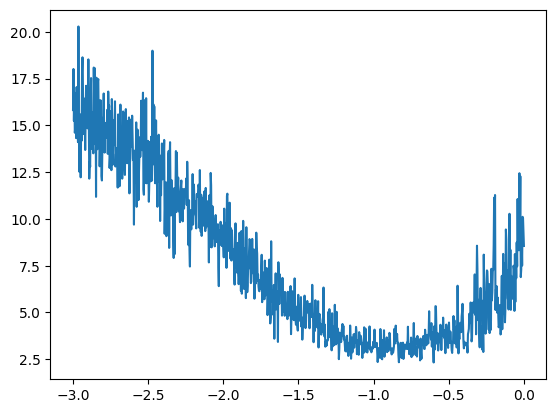

In [54]:
plt.plot(lri,lossi) # -1.0 was a good lre

In [62]:
# enable gradients
for p in parameters:
    p.requires_grad = True


lri = []
lossi = []
# training loop
for i in range(10000):

    # mini-batch contruct
    ix = torch.randint(0, X.shape[0], (32,))

    # -------- forward pass --------
    emb = C[X[ix]]  # (32, 3, 2) 32 is batch size
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # -------- backward pass --------
    for p in parameters:
        p.grad = None

    loss.backward()

    # -------- update --------
    # lr = lrs[i]
    lr = 10**-1 # 0.1 then dec to 0.01 so that decay approach is replicated
    lr = 10**-2
    for p in parameters:
        p.data += -lr * p.grad

    # # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

print(loss.item())

2.3581202030181885


In [63]:
emb = C[X]  # (32, 3, 2) 32 is batch size
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Y)
loss # loss on entire dataset

tensor(2.2531, grad_fn=<NllLossBackward0>)

## train/val/test split

In [ ]:
# train , val , test split 
# 80 10 10

In [69]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [70]:
len(words)

32033

In [71]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [72]:
def build_dataset(words):
    # build the dataset
    block_size = (
        3  # context length: how many characters do we take to predict the next one?
    )
    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X, Y

In [73]:
import random 
random.seed(42)

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtr, Ytr = build_dataset(words[:n2])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([205280, 3]) torch.Size([205280])


# ---------------- now made respectable :) ----------------

In [83]:
# dataset
Xtr.shape, Ytr.shape

(torch.Size([205280, 3]), torch.Size([205280]))

In [116]:
# reproducibility
g = torch.Generator().manual_seed(2147483647)

# parameters
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

# total number of parameters
sum(p.nelement() for p in parameters)

11897

In [117]:
# enable gradients
for p in parameters:
    p.requires_grad = True

In [118]:
# learning rate sweep
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [119]:
lri = []
lossi = []
stepi = []

In [125]:
# training loop
for i in range(50000):

    # -------- minibatch construct --------
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # -------- forward pass --------
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # -------- backward pass --------
    for p in parameters:
        p.grad = None

    loss.backward()

    # -------- update --------
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # -------- track --------
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)
print(loss.item())

2.289445161819458


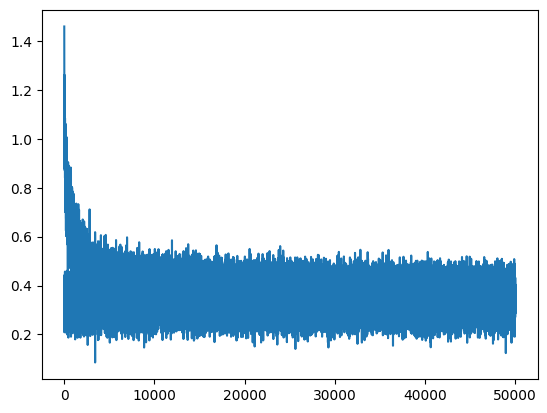

In [126]:
plt.plot(stepi,lossi) # thicknes/noise bec of mini batches

2 embed 

In [102]:
# Eval on train data
emb = C[Xtr]  # (32, 3, 2) 32 is batch size
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss  # loss on entire dataset

tensor(2.2976, grad_fn=<NllLossBackward0>)

In [103]:
# Eval
emb = C[Xdev]  # (32, 3, 2) 32 is batch size
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss  # loss on entire dataset

tensor(2.2903, grad_fn=<NllLossBackward0>)

In [ ]:
# maybe bottle neck is no. of neurons --> increased
# maybe now bottle neck is embedding size (2)

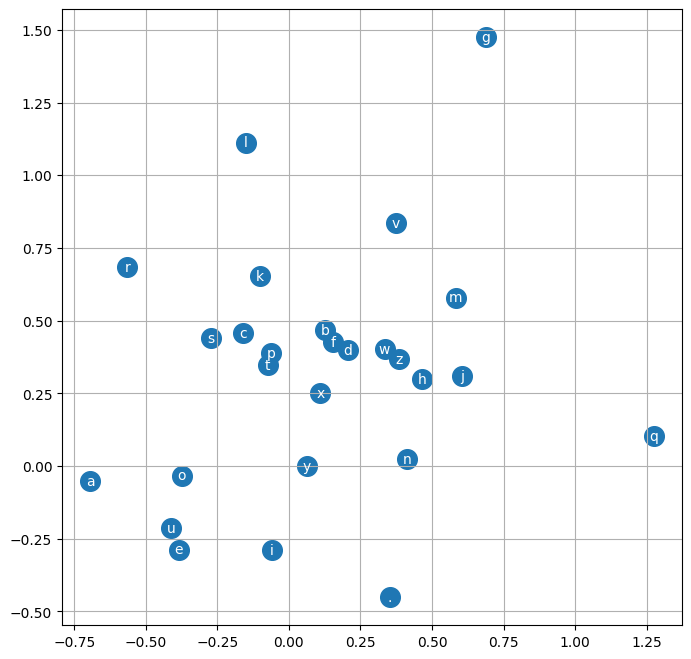

In [105]:
# visualise embeddings after training ALWAYS
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

30 embed

In [127]:
# Eval on train data
emb = C[Xtr]  # (32, 3, 2) 32 is batch size
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss  # loss on entire dataset

tensor(2.1684, grad_fn=<NllLossBackward0>)

In [128]:
# Eval
emb = C[Xdev]  # (32, 3, 2) 32 is batch size
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss  # loss on entire dataset

tensor(2.1659, grad_fn=<NllLossBackward0>)

## sampel from model

In [129]:
block_size

3

In [130]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...

    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print("".join(itos[i] for i in out))

carman.
amille.
khirmili.
taty.
skanden.
jazone.
favery.
chareen.
ner.
kentcheigh.
kaleig.
dham.
jois.
quintis.
lilea.
jadiquiquel.
giearynix.
kae.
pirra.
med.
